In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

In [2]:
def bgr2rgb(img):
    b,g,r = cv.split(img)
    return cv.merge([r,g,b])

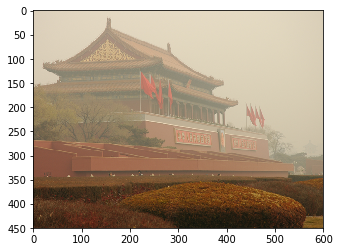

In [3]:
img = bgr2rgb(cv.imread("images/tiananmen1.png"))
plt.imshow(img);

## Obtaining the Dark Channel Prior
The dark channel prior is defined as: $$J^{dark}(x) = \min_{c \in \{r,g,b\}}(\min_{y \in \Omega(x)}(J^{c}(y)))$$

$\mathbf{J}$ is our image, $J^{c}$ is defined as a color channel of our image (one of red, blue, or green), and $\Omega(x)$ is a patch of pixels centered at $x$. 

Intuitively, $J^{dark}$ should be low in a haze-free region of the image.

In [4]:
def get_dark_channel_prior(img, omega=15):
    """
    img   -> 3D tensor in RGB format
    omega -> size of patch to consider (default is 15)
    """
    J_dark = np.ones(img.shape[:2])    
    padded = np.pad(img, ((omega//2,),(omega//2,),(0,)), 'edge')
    
    footprint = np.ones((omega,omega,3))
    
    J_dark = ndimage.minimum_filter(img,footprint=footprint,mode='nearest')
            
    return J_dark[:,:,1]

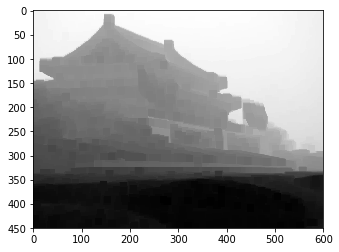

In [5]:
tian_jdark = get_dark_channel_prior(img)
plt.imshow(tian_jdark, cmap='gray');

## Estimation of Atmospheric Light
We assume that the atmospheric light is a constant for each channel. Also, we calculate the atmospheric light for each channel in the image since Equation (6) references $A^{c}$, indicating that $A$ is different depending on what channel that is being used in the calculations.

The procedure is as follows:
1. Calculate the dark channel prior.
2. Pick the 0.1% brightest pixels in the dark channel.
3. Find the maximum intensity among the pixels in the original image $I$ for each of the channels.

In [6]:
def estimate_atmospheric_light(img):
    """
    img -> 3D tensor in RGB format
    
    ret -> 
        A_r |
        A_g | -> estimated atmospheric light in the RGB channels
        A_c |
    """
    size = img.shape[:2]
    k = int(0.001*np.prod(size))
    j_dark = get_dark_channel_prior(img)
    idx = np.argpartition(-j_dark.ravel(),k)[:k]
    x, y = np.hsplit(np.column_stack(np.unravel_index(idx, size)), 2)
    
    A_r, A_g, A_b = img[x,y,0].max(), img[x,y,1].max(), img[x,y,2].max()
    return A_r, A_g, A_b

Here, we replicate the detection of atmospheric light, similar to figure 7 (first row, third column). The pixels we inspect for the atmospheric light is in the same region as that of the paper's.

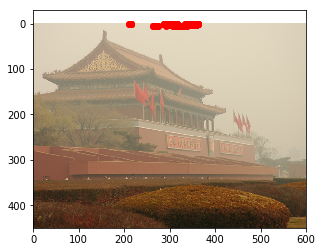

In [7]:
size = img.shape[:2]
k = int(0.001*np.prod(size))
idx = np.argpartition(-tian_jdark.ravel(),k)[:k]
zz = np.column_stack(np.unravel_index(idx, tian_jdark.shape))
x, y = np.hsplit(zz,2)
plt.imshow(img)
plt.scatter(y, x, c='r')
plt.show()

## 4.1 Estimating the Transmission

In [8]:
def estimate_transmission(img, omega=0.95):
    """
    Estimates the transmission map using the dark channel prior of the normalized image. 
    A small fraction, omega, of the haze is kept to retain depth perspective after haze removal.
    
    img   -> 3D Tensor in RGB format
    omega -> fraction of haze to keep in image (default is 0.95)
    """
    A_r, A_g, A_b = estimate_atmospheric_light(img)
    norm_img = img / np.array([A_r, A_g, A_b])
    norm_img_dc = get_dark_channel_prior(norm_img)

    return 1 - omega*norm_img_dc

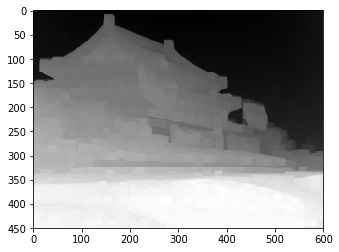

In [9]:
alpha_map = estimate_transmission(img)
plt.imshow(alpha_map, cmap='gray');

In [10]:
def guided_filter(I, p, omega=60, eps=0.01):
    """
    from http://kaiminghe.com/publications/eccv10guidedfilter.pdf
    and  https://arxiv.org/pdf/1505.00996.pdf
    
    I     -> guidance image, 3D Tensor in RGB format
    p     -> filtering input image, 
    omega -> window size (default is 60)
    eps   -> constant to prevent division by 0 (default 0.01)
    """
    
    I = cv.cvtColor(I, cv.COLOR_RGB2GRAY)/255
    w_size = (omega,omega)
    
    mean_I = cv.blur(I, w_size)
    mean_p = cv.blur(p, w_size)
    
    corr_I = cv.blur(I*I, w_size)
    corr_Ip = cv.blur(I*p, w_size)
    
    var_I = corr_I - mean_I*mean_I
    cov_Ip = corr_Ip - mean_I*mean_p
    
    a = cov_Ip/(var_I + eps)
    b = mean_p - a*mean_I
    
    mean_a = cv.blur(a, w_size)
    mean_b = cv.blur(b, w_size)
    
    return mean_a*I + mean_b
    

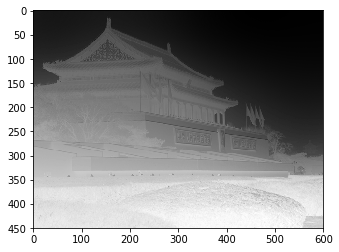

In [11]:
f_alpha_map = guided_filter(img, alpha_map, 200, eps=0.01)
plt.imshow(f_alpha_map, cmap="gray");

246


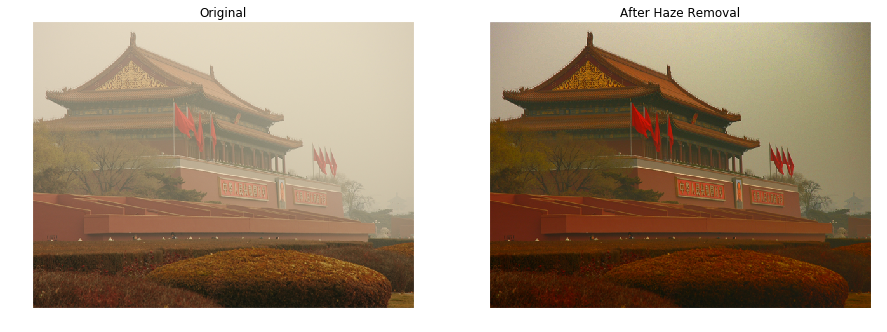

In [25]:
A_r, A_g, A_b = estimate_atmospheric_light(img)
f_alpha_map = guided_filter(img, alpha_map, 300, eps=0.01)
l = bgr2rgb(cv.imread("images/tiananmen1.png"))
l = l.astype(np.int16)

l[:,:,0] = l[:,:,0] - A_r
l[:,:,1] = l[:,:,1] - A_g
l[:,:,2] = l[:,:,2] - A_b

z = np.maximum(f_alpha_map, 0.1)
l[:,:,0]=  l[:,:,0]/z
l[:,:,1] = l[:,:,1]/z
l[:,:,2] = l[:,:,2]/z

# l = np.maximum(l, 0)
l[:,:,0] += A_r
l[:,:,1] += A_g
l[:,:,2] += A_b

l = np.maximum(l, 0)

print(l.max())

im = bgr2rgb(cv.imread("images/tiananmen1.png"))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))

ax1.imshow(im)
ax1.set_title("Original")
ax1.axis('off')

ax2.imshow(l)
ax2.set_title("After Haze Removal")
ax2.axis('off');